In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from pysheds.grid import Grid
from pysheds.view import Raster
import skimage.morphology
import skimage.segmentation
from itertools import zip_longest, cycle, permutations
from scipy import ndimage
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
class Node:
    def __init__(self, name=None, parent=None, l=None, r=None, level=None, elev=None,
                 comm=None, t=None, vol=0, current_vol=0):
        self.name = name
        self.parent = parent
        self.l = l
        self.r = r
        self.t = t
        self.elev = elev
        self.comm = comm
        self.level = level
        self.vol = vol
        self.current_vol = current_vol

def marginal_vol(node):
    if node.l and node.r:
        if node.l is node.r:
            node.vol -= node.l.vol
            node.vol = max(node.vol, 0)
            marginal_vol(node.l)
        else:
            node.vol -= node.l.vol
            node.vol -= node.r.vol
            node.vol = max(node.vol, 0)
            marginal_vol(node.l)
            marginal_vol(node.r)
        
def enumerate_leaves(node, level=0, stack=[]):
    if node.level >= level:
        if node.name:
            stack.append(node.name)
        if node.l:
            enumerate_leaves(node.l, level=level, stack=stack)
        if node.r:
            enumerate_leaves(node.r, level=level, stack=stack)

def map_nodes(node, op=(lambda x: None), *args, **kwargs):
    if node.l:
        map_nodes(node.l, op=op, *args, **kwargs)
    if node.r:
        map_nodes(node.r, op=op, *args, **kwargs)
    op(node, *args, **kwargs)

def accumulate(x, accumulator):
    accumulator += (x.vol)
        
def get_root(node):
    if node.parent:
        return get_root(node.parent)
    else:
        return node

def show_tree(tree):
    depth = ""
    treestr = ""

    def print_push(char):
        nonlocal depth
        branch_str = ' {}  '.format(char)
        depth += branch_str

    def print_pop():
        nonlocal depth
        depth = depth[:-4]

    def print_tree(node):
        nonlocal depth
        nonlocal treestr
        if (node.l or node.r):
            if (node.name):
                treestr += '({0}-{1})\n'.format(node.level, node.name)
            else:
                treestr += '{0}{1}\n'.format(chr(9472), '+')
            treestr += '{0} {1}{2}{2}'.format(depth, chr(9500), chr(9472))
            print_push(chr(9474))
            print_tree(node.l)
            print_pop()
            treestr += '{0} {1}{2}{2}'.format(depth, chr(9492), chr(9472))
            print_push(' ')
            print_tree(node.r)
            print_pop()
        else:
            treestr += '({0}-{1})\n'.format(node.level, node.name)

    print_tree(tree)
    return treestr

def show_vol(tree):
    depth = ""
    treestr = ""

    def print_push(char):
        nonlocal depth
        branch_str = ' {}  '.format(char)
        depth += branch_str

    def print_pop():
        nonlocal depth
        depth = depth[:-4]

    def print_tree(node):
        nonlocal depth
        nonlocal treestr
        if (node.l or node.r):
            if (node.name):
                treestr += '({0:.2f} | {1:.2f})\n'.format(node.current_vol, node.vol)
            else:
                treestr += '({0:.2f} | {1:.2f})\n'.format(node.current_vol, node.vol)
            treestr += '{0} {1}{2}{2}'.format(depth, chr(9500), chr(9472))
            print_push(chr(9474))
            print_tree(node.l)
            print_pop()
            treestr += '{0} {1}{2}{2}'.format(depth, chr(9492), chr(9472))
            print_push(' ')
            print_tree(node.r)
            print_pop()
        else:
            treestr += '({0:.2f} | {1:.2f})\n'.format(node.current_vol, node.vol)

    print_tree(tree)
    return treestr

def traverse(node):
    if node.l:
        traverse(node.l)
    if node.r:
        traverse(node.r)
    if node.parent:
        if node.name:
            elevdiff = node.parent.elev - dem[ws[node.level] == node.name]
            vol = abs(np.asscalar(elevdiff[elevdiff > 0].sum()) * x * y)
            node.vol = vol
#            print(node.level, node.name, node.vol, node.parent.elev)
        else:
            leaves = []
            enumerate_leaves(node, level=node.level, stack=leaves)
            elevdiff = node.parent.elev - dem[np.isin(ws[node.level], leaves)]
            vol = abs(np.asscalar(elevdiff[elevdiff > 0].sum()) * x * y)
            node.vol = vol
#            print(node.level, leaves, node.vol, node.parent.elev)

def isleaf(node):
    if node.l or node.r:
        return True
    else:
        return False

In [3]:
def compute_vol(z, node, target_vol):
    if node.name:
        full = z - dem[ws[node.level] == node.name]
    else:
        leaves = []
        enumerate_leaves(node, level=node.level, stack=leaves)
        full = z - dem[np.isin(ws[node.level], leaves)]
    vol = abs(np.asscalar(full[full > 0].sum()) * x * y)
    return vol - target_vol

In [4]:
def traverse_levels(node, waterlevel):
    if node.current_vol > 0:
        maxelev = node.parent.elev
        if node.elev:
            minelev = node.elev
        else:
            # TODO: This bound could be a lot better
            minelev = 0
        under_vol = np.array(0, dtype=float)
        if node.l:
            map_nodes(node.l, op=accumulate, accumulator=under_vol)
        if node.r:
            map_nodes(node.r, op=accumulate, accumulator=under_vol)
        target_vol = node.current_vol + under_vol
        elev = scipy.optimize.bisect(compute_vol, minelev, maxelev,
                                     args=(node, target_vol))
        if node.name:
            ix = ws[node.level] == node.name
        else:
            leaves = []
            enumerate_leaves(node, level=node.level, stack=leaves)
            ix = np.isin(ws[node.level], leaves)
        fullindex = np.flatnonzero(ix & (dem < elev))
        waterlevel.flat[fullindex] = elev    
    else:
        if node.l:
            traverse_levels(node.l, waterlevel)
        if node.r and (not node.l is node.r):
            traverse_levels(node.r, waterlevel)

In [5]:
def check_overflow(node, overflowing):
    overflowing |= np.array(node.current_vol > node.vol, dtype=bool)
    if not overflowing:
        if node.l:
            check_overflow(node.l, overflowing)
        if node.r:
            check_overflow(node.r, overflowing)

In [6]:
def node_full(node):
    # TODO: This should be generalized using recursion
    if node.vol == 0:
        if node.l and node.r:
            return (node.l.current_vol >= node.l.vol) and (node.r.current_vol >= node.r.vol)
        else:
            return True
    return node.current_vol >= node.vol

In [7]:
# Need stopping condition
def top_down(node):
    # Pull up
    if (node.l and node.r):
        singleton = (node.l is node.r)
        if node_full(node.l) and node_full(node.r):
            ltransfer = node.l.current_vol - node.l.vol
            rtransfer = node.r.current_vol - node.r.vol
            node.l.current_vol -= ltransfer
            node.current_vol += ltransfer
            if not singleton:
                node.r.current_vol -= rtransfer
                node.current_vol += rtransfer
    # Push down
    if (node.current_vol > node.vol) and (node.t):
        transfer = node.current_vol - node.vol
        node.current_vol -= transfer
        node.t.current_vol += transfer
    if node.l:
        top_down(node.l)
    if node.r:
        top_down(node.r)

In [8]:
grid = Grid.from_raster('../data/roi_10m', data_name='dem')
x, y = abs(grid.affine.a), abs(grid.affine.e)

In [9]:
dem = grid.view('dem')[30:130, 280:350]

In [10]:
# Identify depressions in DEM
ix = np.arange(dem.size).reshape(dem.shape)
top = ix[0, :]
bottom = ix[-1, :]
left = ix[:, 0]
right = ix[:, -1]

# Rotate the barrier to ensure that all depressions touching edges are captured
holes = np.zeros(dem.shape)
for permutation in permutations([top, bottom, left, right], 3):
    mask = np.copy(dem)
    exterior = np.concatenate(permutation)
    mask.flat[exterior] = dem.max()
    seed = np.copy(mask)
    seed[1:-1, 1:-1] = dem.max()
    rec = skimage.morphology.reconstruction(seed, mask, method='erosion')
    holes[(rec - dem) > 0] = dem[(rec - dem) > 0]

# Not sure if this is needed
holes[0, :] = 0
holes[-1, :] = 0
holes[:, 0] = 0
holes[:, -1] = 0

In [11]:
max_levels = 100
levels = []
mask = np.where(holes == 0, holes.min(), holes)
seed = np.where(holes == 0, mask, holes.max())
rec = skimage.morphology.reconstruction(seed, mask, method='erosion')
levels.append(rec)

for _ in range(max_levels):
    diff = rec - mask
    holes = np.where(diff, holes, 0)
    mask = np.where(holes == 0, holes.min(), holes)
    seed = np.where(holes == 0, mask, holes.max())
    rec = skimage.morphology.reconstruction(seed, mask, method='erosion')
    if not rec.any():
        break
    levels.append(rec)
    
levels = levels[::-1]
levels.append(np.ones(dem.shape))

In [12]:
# Label depressions
struct = np.ones((3,3), dtype=bool)

ns = []
for index, level in enumerate(levels):
    _level, _n = ndimage.label(level, structure=struct)
    levels[index] = _level
    ns.append(_n)

In [13]:
lup = {}
ct = {}
has_lower = []
for n in ns:
    has_lower.append(np.zeros(n + 1, dtype=bool))

for index in range(len(levels) - 1):
    labelmap = pd.Series(levels[index + 1][levels[index] != 0],
                         index=levels[index][levels[index] != 0]).groupby(level=0).first()
    lup[index] = dict(labelmap)
    ct[index] = dict(labelmap.value_counts())
    has_lower[index + 1][labelmap.unique()] = True

In [14]:
ws = []
for index in range(len(levels) - 1):
    mask = (has_lower[index + 1][levels[index + 1]])
    w = skimage.morphology.watershed(dem, levels[index],
                                     mask=mask, watershed_line=True)
    w = np.where(mask, w, -1)
    ws.append(w)
ws.append(levels[-1])

In [15]:
c = {}
inside = np.zeros(dem.shape, dtype=bool)
inside[1:-1, 1:-1] = True
for index in range(len(levels) - 1):
    c[index] = {}
    comm = np.flatnonzero((ws[index] == 0) & inside)
    neighbors = ws[index].flat[grid._select_surround_ravel(comm, ws[index].shape)]
    comms = dict(zip(comm, [set() for i in comm]))
    for region in lup[index].keys():
        for elem in comm[(neighbors == region).any(axis=1)]:
            comms[elem].add(region)       
    for elem in comms:
        comms[elem] = tuple(comms[elem])
    for comm, pair in comms.items():
        if len(pair) > 2:
            for permutation in permutations(pair, 2):
                subpair = tuple(sorted(permutation))
                if subpair in c[index]:
                    if dem.flat[comm] < dem.flat[c[index][subpair]]:
                        c[index][subpair] = comm
                else:
                    c[index][subpair] = comm
        else:
            if pair in c[index]:
                if dem.flat[comm] < dem.flat[c[index][pair]]:
                    c[index][pair] = comm
            else:
                c[index][pair] = comm

In [16]:
level = []
subnum = []
full = []
n_i = 0

for index, n in enumerate(ns):
    s = np.arange(1, n + 1)
    f = s + n_i
    l = np.repeat(index, n)
    subnum.append(s)
    full.append(f)
    level.append(l)
    n_i += n
level = np.concatenate(level)
subnum = np.concatenate(subnum)
full = np.concatenate(full)
df = pd.DataFrame(np.column_stack([level, subnum]), index=full)

In [17]:
nodes = []
for index in range(len(levels)):
    nodes.append({})
    for i in range(1, ns[index] + 1):
        nodes[index][i] = Node(name=i, level=index)

In [18]:
# Figure out where each drop will end
drop = skimage.morphology.watershed(dem, np.where(ws[0] > 0, ws[0], 0), mask=ws[1] > 0)
for index in range(1, len(ws) - 1):
    num_lower = sum(ns[:index])
    base = drop + np.where((ws[index] > 0) & (drop == 0), num_lower + ws[index], 0)
    drop = skimage.morphology.watershed(dem, base, mask=ws[index + 1] > 0)

In [19]:
tmap = []

for index in range(len(levels) - 1):
    g = set(range(1, ns[index] + 1))
    s = pd.DataFrame(pd.Series(c[index]))
    s[0] = s[0].astype(int)
    s[1] = dem.flat[s[0].values]
    s[2] = [lup[index][i] for i in s.index.get_level_values(0)]
    s = s.sort_values(1)
    num_connections = dict(s.groupby(2).size())
    tmap.append({})
    
    for i in s.index:
        l = nodes[index][i[0]]
        r = nodes[index][i[1]]
        # Kind of ugly, but need to make sure both haven't been added already
        # TODO: This could be introducing a bug, because it's eliminating a connection
        if not (get_root(l) is get_root(r)):
            parent = Node()
            parent.comm = s.loc[i, 0]
            parent.elev = s.loc[i, 1]
            parent.level = index
            upper_label = int(s.loc[i, 2])
            tmap[index][i] = parent
            # Join watersheds at same level
            for j, d in zip(i, ('l', 'r')):
                g.discard(j)
                child = get_root(nodes[index][j])
                child.parent = parent
                setattr(parent, d, child)
            num_connections[upper_label] -= 1
            # If all watersheds in the depressions have been joined, move up
            if num_connections[upper_label] == 0:
                parent.level = (index + 1)
                parent.name = upper_label
                nodes[index + 1][parent.name] = parent
        else:
            num_connections[upper_label] -= 1
    if g:
        for j in g:
            upper_label = lup[index][j]
            child = nodes[index][j]
            parent = nodes[index + 1][upper_label]
            parent.elev = np.asscalar(dem[levels[index + 1] == upper_label].min())
            child.parent = parent
            parent.l = child
            parent.r = child
            nodes[index][j] = child
            nodes[index + 1][parent.name] = parent
            
traverse(nodes[-1][1])
nodes[-1][1].vol = np.inf
marginal_vol(nodes[-1][1])

In [20]:
print(show_tree(nodes[-1][1]))

(5-1)
 ├──(4-1)
 └───+
     ├──(4-3)
     └───+
         ├───+
         │   ├──(4-5)
         │   └───+
         │       ├──(4-2)
         │       │   ├───+
         │       │   │   ├──(3-2)
         │       │   │   └──(3-3)
         │       │   └───+
         │       │       ├──(3-1)
         │       │       │   ├──(2-1)
         │       │       │   └───+
         │       │       │       ├──(2-2)
         │       │       │       └───+
         │       │       │           ├───+
         │       │       │           │   ├──(2-3)
         │       │       │           │   └──(2-4)
         │       │       │           │       ├──(1-1)
         │       │       │           │       └───+
         │       │       │           │           ├──(1-2)
         │       │       │           │           │   ├──(0-1)
         │       │       │           │           │   └──(0-2)
         │       │       │           │           └──(1-3)
         │       │       │           └──(2-5)
         │       │       └

In [21]:
for index, mapping in enumerate(tmap):
    for pair, node in mapping.items():
        i, j = pair
        comm = int(node.comm)
        comm_elev = node.elev
        neighbors = grid._select_surround_ravel(comm, dem.shape)
        ser = pd.DataFrame(np.column_stack([neighbors, dem.flat[neighbors], ws[index].flat[neighbors]]))
        ser = ser[ser[2].isin(list(pair))]
        g = ser.groupby(2).idxmin()[1].apply(lambda x: ser.loc[x, 0])
        fullix = drop.flat[g.values.astype(int)]
        lv = df.loc[fullix][0].values
        nm = df.loc[fullix][1].values
        g = pd.DataFrame(np.column_stack([lv, nm]), index=g.index.values.astype(int),
                         columns=['level', 'name']).to_dict(orient='index')
        # Children will always be in numeric order from left to right
        lt, rt = g[j], g[i]
        node.l.t = nodes[lt['level']][lt['name']]
        node.r.t = nodes[rt['level']][rt['name']]

In [22]:
def set_singleton(node):
    if node.l:
        set_singleton(node.l)
    if node.r:
        set_singleton(node.r)
    if node.parent:
        if node.parent.l is node.parent.r:
            node.t = node.parent

set_singleton(nodes[-1][1])

In [23]:
v = pd.DataFrame(np.column_stack([df[0].loc[drop.ravel()].values, df[1].loc[drop.ravel()].values,
                                  0.1*900*np.ones(dem.size)])).groupby([0,1]).sum().reset_index()
v[0] = v[0].astype(int)
v[1] = v[1].astype(int)
v = v.sort_values([0,1])
v

,0,1,2
0,0,1,55620.0
1,0,2,11520.0
2,1,1,43380.0
3,1,3,71730.0
4,2,1,27270.0
5,2,2,40770.0
6,2,3,7830.0
7,2,5,43740.0
8,2,6,148500.0
9,3,2,98370.0


In [24]:
for level, name, vol in zip(v[0].values, v[1].values, v[2].values):
    node = nodes[level][name]
    node.current_vol = vol

In [25]:
print(show_vol(nodes[-1][1]))

(0.00 | inf)
 ├──(630.00 | 14220.04)
 └──(0.00 | 634698230.71)
     ├──(22590.00 | 1709.91)
     └──(0.00 | 6304753.02)
         ├──(0.00 | 150419057.08)
         │   ├──(21420.00 | 1506961.67)
         │   └──(0.00 | 19695496.07)
         │       ├──(0.00 | 97561570.94)
         │       │   ├──(0.00 | 0.00)
         │       │   │   ├──(98370.00 | 269.93)
         │       │   │   └──(8370.00 | 359.91)
         │       │   └──(0.00 | 12644179.98)
         │       │       ├──(0.00 | 4490984.73)
         │       │       │   ├──(27270.00 | 810.02)
         │       │       │   └──(0.00 | 265605.14)
         │       │       │       ├──(40770.00 | 1979.85)
         │       │       │       └──(0.00 | 183052.00)
         │       │       │           ├──(0.00 | 0.00)
         │       │       │           │   ├──(7830.00 | 629.96)
         │       │       │           │   └──(0.00 | 978746.26)
         │       │       │           │       ├──(43380.00 | 5400.00)
         │       │       │           │

In [26]:
max_iter = 100
cur_iter = 0

for _ in range(max_iter):
    overflowing = np.array(False, dtype=bool)
    check_overflow(nodes[-1][1], overflowing)
    if not overflowing:
        break
    top_down(nodes[-1][1])
    cur_iter += 1

In [27]:
cur_iter

2

In [28]:
print(show_vol(nodes[-1][1]))

(0.00 | inf)
 ├──(630.00 | 14220.04)
 └──(0.00 | 634698230.71)
     ├──(1709.91 | 1709.91)
     └──(0.00 | 6304753.02)
         ├──(0.00 | 150419057.08)
         │   ├──(21420.00 | 1506961.67)
         │   └──(0.00 | 19695496.07)
         │       ├──(0.00 | 97561570.94)
         │       │   ├──(0.00 | 0.00)
         │       │   │   ├──(269.93 | 269.93)
         │       │   │   └──(359.91 | 359.91)
         │       │   └──(0.00 | 12644179.98)
         │       │       ├──(0.00 | 4490984.73)
         │       │       │   ├──(810.02 | 810.02)
         │       │       │   └──(0.00 | 265605.14)
         │       │       │       ├──(1979.85 | 1979.85)
         │       │       │       └──(0.00 | 183052.00)
         │       │       │           ├──(0.00 | 0.00)
         │       │       │           │   ├──(629.96 | 629.96)
         │       │       │           │   └──(0.00 | 978746.26)
         │       │       │           │       ├──(5400.00 | 5400.00)
         │       │       │           │       └─

In [29]:
waterlevel = np.zeros(dem.shape)

In [30]:
traverse_levels(nodes[-1][1], waterlevel)

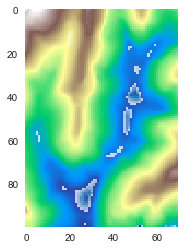

In [31]:
plt.imshow(np.where(waterlevel, waterlevel - dem, np.nan), zorder=2, cmap='Blues', alpha=0.8)
plt.imshow(dem, zorder=1, cmap='terrain')

In [32]:
v[2].sum()

630000.0

In [33]:
np.nansum(np.where(waterlevel, waterlevel - dem, np.nan) * x * y)

630000.714111338